<h1>Analysis of Variance</h1>


In [38]:
import polars as pl
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt

%matplotlib inline

As a dataset we use oservations of teeth length of guinea pigs given different doses - 0.5, 1, 2 mg - of vitamin C of two different forms - orange juice and just vitamin C.

In this example we will use only Dose factor.


In [39]:
teeth_df = pl.read_csv("../datasets/ToothGrowth.csv")
teeth_df.head()

,len,supp,dose
i64,f64,str,f64
1,4.2,"""VC""",0.5
2,11.5,"""VC""",0.5
3,7.3,"""VC""",0.5
4,5.8,"""VC""",0.5
5,6.4,"""VC""",0.5


In [40]:
teeth_df.describe()

describe,,len,supp,dose
str,f64,f64,str,f64
"""count""",60.0,60.0,"""60""",60.0
"""null_count""",0.0,0.0,"""0""",0.0
"""mean""",30.5,18.813333,null,1.166667
"""std""",17.464249,7.649315,null,0.628872
"""min""",1.0,4.2,"""OJ""",0.5
"""25%""",16.0,13.6,null,0.5
"""50%""",31.0,19.7,null,1.0
"""75%""",45.0,25.2,null,2.0
"""max""",60.0,33.9,"""VC""",2.0


<h2>Hypotheses</h2>
H<sub>0</sub>: There is no difference among 'dose' group means. The average teeth length will be the same among 'dose' groups.

H<sub>1</sub>: At least one group differs significantly from the overall mean of teeth length.


## Manual calculations


In order to manually proceed ANOVA we use ANOVA table:


| Source of Variation | Sum of Squares | Degrees of Freedom | Mean Squares | F-value |
| :-: | :-: | :-: | :-: | :-: |
| Between groups | SS<sub>between</sub> | DF<sub>between</sub> | MS<sub>between</sub> | F-value |
| Within groups | SS<sub>within</sub> | DF<sub>within</sub> | MS<sub>within</sub> |  |
| Total | SS<sub>total</sub> | DF<sub>total</sub> | MS<sub>total</sub> |  |


| Source of Variation | Sum of Squares | Degrees of Freedom | Mean Squares | F-value |
| :-: | :-: | :-: | :-: | :-: |
| Between groups | $\sum n(\overline{x}_i-GM)^2$ | Number of groups - 1 | $\frac{SS_\text{between}}{DF_\text{between}}$ | $\frac{MS_\text{between}}{MS_\text{within}}$ |
| Within groups | $\sum (x_i - \overline{x})^2$ | DF<sub>total</sub> - DF<sub>between</sub> | $\frac{SS_\text{within}}{DF_\text{within}}$ |  |
| Total | $\sum (x_i - GM)^2$ | Number of samples - 1 |  |  |


### Global Mean

At first we calculate Global Mean (GM), which is an estimate of the population mean.


In [41]:
GM = teeth_df.select("len").mean().item()
print(f"Global mean = {GM}")

Global mean = 18.813333333333336


### Sum of Squares between groups


To calculate $SS_\text{between}$ we use next formula:

$$SS_\text{between} = \sum n(\overline{x}_i-GM)^2$$

where:

$n$ - number of samples in a particular group

$\overline{x}$ - mean of a group

$GM$ - global mean


Let's calculate mean and $n$ of each group:


In [42]:
groupped_by_dose = (
    teeth_df.group_by("dose").agg(mean=pl.mean("len"), count=pl.count()).sort("dose")
)
groupped_by_dose

dose,mean,count
f64,f64,u32
0.5,10.605,20
1.0,19.735,20
2.0,26.1,20


Now we apply given formula to calculate Sum of Squares between groups:


In [50]:
SS_between = (
    groupped_by_dose.with_columns(
        ss_between=pl.col("count") * ((pl.col("mean") - GM) ** 2)
    )
    .select("ss_between")
    .sum()
    .item()
)
print(f"Sum of Squares between groups = {SS_between}")

Sum of Squares between groups = 2426.434333333332


### Sum of Squares within groups


To calculate $SS_\text{within}$ we use next formula:

$$SS_\text{within} = \sum (x_i - \overline{x})^2$$

where:

$x^i$ - particular sample value

$\overline{x}$ - mean of a group


In [49]:
teeth_df_with_mean = teeth_df.join(groupped_by_dose, on="dose", how="left")
SS_within = (
    teeth_df_with_mean.with_columns(
        ss_within=(pl.col("len") - pl.col("mean")) ** 2
    )  # here is the squared difference is calulated
    .select("ss_within")
    .sum()
    .item()
)
print(f"Sum of Squares within groups = {SS_within}")

Sum of Squares within groups = 1025.7750000000003


### Total Sum of Squares


To calculate $SS_\text{total}$ we use next formula:

$$SS_\text{total} = \sum (x_i - GM)^2$$

where:

$x^i$ - particular sample value

$GM$ - global mean


In [48]:
SS_total = (
    teeth_df.with_columns(ss_total=(pl.col("len") - GM) ** 2)
    .select("ss_total")
    .sum()
    .item()
)
print(f"Sum of Squares total = {SS_total}")

Sum of Squares total = 3452.2093333333332


Now we have calculated all Sum of Squares: | Source of Variation | Sum of Squares | Degrees of Freedom | Mean Squares | F-value | | :-: | :-: | :-: | :-: | :-: | | Between groups | 2426.43 | DF<sub>between</sub> | MS<sub>between</sub> | | | Within groups | 1025.78 | DF<sub>within</sub> | MS<sub>within</sub> | | | Total | 3452.21 | DF<sub>total</sub> | MS<sub>total</sub> | |


### Degrees of Freedom


Now we move to Degrees of Freedom.

$$DF_\text{between} = \text{number of groups} - 1$$

$$DF_\text{total} = \text{total number of samples} - 1$$

$$DF_\text{within} = DF_\text{total} - DF_\text{total}$$


In [51]:
DF_between = groupped_by_dose.shape[0] - 1
DF_total = teeth_df.shape[0] - 1
DF_within = DF_total - DF_between
print(f"DF between = {DF_between}")
print(f"DF within = {DF_within}")
print(f"DF total = {DF_total}")

DF between = 2
DF within = 57
DF total = 59


Now we have calculated all Degrees of Freedom:

| Source of Variation | Sum of Squares | Degrees of Freedom | Mean Squares | F-value |
| :-: | :-: | :-: | :-: | :-: |
| Between groups | 2426.43 | 2 | MS<sub>between</sub> |  |
| Within groups | 1025.78 | 57 | MS<sub>within</sub> |  |
| Total | 3452.21 | 59 | MS<sub>total</sub> |  |


### Mean Squares


We divide Sum of Squares by degrees of freedom for both Between and Within rows.

Mean Squares are calculated using the equation below:


$$\frac{\text{Sum of Squares}}{\text{Degrees of Freedom}}$$


In [53]:
MS_between = SS_between / DF_between
MS_within = SS_within / DF_within
print(f"MS between = {MS_between}")
print(f"MS within = {MS_within}")

MS between = 1213.217166666666
MS within = 17.99605263157895


Now we have calculated all Degrees of Freedom:

| Source of Variation | Sum of Squares | Degrees of Freedom | Mean Squares | F-value |
| :-: | :-: | :-: | :-: | :-: |
| Between groups | 2426.43 | 2 | 1213.22 |  |
| Within groups | 1025.78 | 57 | 18.00 |  |
| Total | 3452.21 | 59 |  |  |


<h2>Explanation</h2>

Let's have a closer look on MS<sub>within</sub> calculation:

$$MS_\text{within} = \frac{\text{Sum of Squares within groups}}{\text{Degrees of freedom within groups}} = \frac{\sum (x_i - \overline{x})^2}{(\text{Total samples}-1)-(\text{Number of groups} -1)}$$


This is very close to the sample variance calculation:

$$\text{Sample Variance} = s^2 = \frac{\text{Sum of Squares}}{\text{Degrees of freedom}} = \frac{\sum (x_i - \overline{x})^2}{n-1}$$


Generaly, MS<sub>between</sub> and MS<sub>within</sub> are both unique and different estimates of the population variance.

MS<sub>within</sub> is an estimate of the population variance that's based on the variability within each treatment group.

MS<sub>between</sub> is an estimate of the population variance that's based on the variability between the group sample means and the global mean.

**Thus if our H<sub>0</sub> is true then these two estimates of the population variance should be approximately equal.**


### F-value


Now we compare $MS_\text{between}$ and $MS_\text{within}$ using the F-test.

If the null hypothesis is true both $MS_\text{between}$ and $MS_\text{within}$ will approximate the population variance, and $MS_\text{between} \approx MS_\text{within}$, and F-value will be $\approx 1$.

If the null hypothesis is false, and one or more sample groups are not equal to the other sample groups, then our F-value will be $\gt 1$


$$\text{F-value} = \frac{MST}{MSE}$$


In [54]:
f_value = MS_between / MS_within
print(f"F-value = {f_value}")

F-value = 67.41573785674241


The F-Test allows us to determine if our differences between $MS_\text{between}$ and $MS_\text{within}$ are due to chance or if they are statistically significant.

We can calculate critical F-value (based on our alpha risk and degrees of freedom) and P-value, that represents the probability of getting that big of a difference between $MS_\text{between}$ and $MS_\text{within}$ (or bigger). This P-value can be compared to your alpha risk to make an accept/reject decision.


Critical value: 3.16, Value: 67.41573785674241, p_value: 0.000


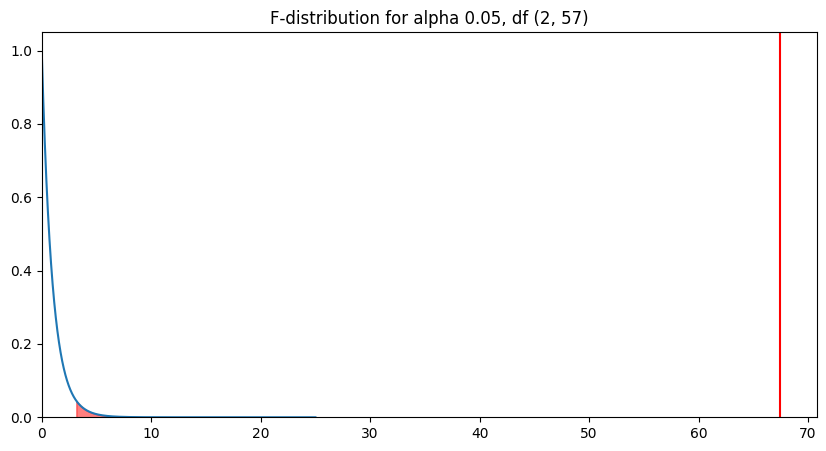

In [55]:
x = np.arange(0, 25, 0.001)
critical_value = f.ppf(0.95, DF_between, DF_within)
p_value = f.sf(f_value, DF_between, DF_within)
print(f"Critical value: {critical_value:.2f}, Value: {f_value}, p_value: {p_value:.3f}")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, f.pdf(x, DF_between, DF_within))
ax.axvline(f_value, color="red")
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_title(f"F-distribution for alpha 0.05, df {DF_between, DF_within}")
ax.fill_between(
    x, f.pdf(x, DF_between, DF_within), where=x > critical_value, color="red", alpha=0.5
)
plt.show()

Here we see the great difference between our F-value and critical F-value. Thus we reject our H<sub>0</sub> hypothesis.
